# PART 3 - CREATE FEATURES AND CLUSTER
This notebook combines the outputs of topic modelling and the sentiment analysis to create features that can be used to cluster.<br>
Reads the sentiment analysis outputs - 1. sentiment train csv 2. sentiment test csv <br>
Reads the topic modeling outputs - 1. LDA pipe 2. train vector 3. test vector

writes
MinMaxScaler pipeline -> used for scalerization (dill dump)
../data/final_train.csv -> train file ready for cosine-similarity or clustering ...
../data/final_test.csv -> test file ready for cosine-similarity or clustering ...
../data/final_full.csv -> the final file ready for cosine-similarity or clustering ... (what we use in the app.py) to find a similar book

<font color ='blue'> runs fairly fast.. </font>


In [1]:
from __future__ import print_function
# key libs
import numpy as np
import re
import nltk
import pandas as pd
import glob
import codecs

# nlp libs
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

# processing
from sklearn.model_selection import train_test_split

# LDA
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF


# bring in my pickled vectorizers
import pickle
import dill


In [2]:
# what are we interestd in
# set this up to read the correct set of files we are interested in
topic_model = 'lda'
n_gram = '1gm' # options - 1gm , 2gm
stem_type = 'lemma' # options - lemma,snow

In [3]:
# set random state
RSEED = 0

### 1. OPEN - SENTIMENT ANALYSIS


In [4]:
sentiment_train=pd.read_csv('../data/sentiment_train.csv')
sentiment_test=pd.read_csv('../data/sentiment_test.csv')
sentiment_train = sentiment_train.drop(columns='Unnamed: 0')
sentiment_test = sentiment_test.drop(columns='Unnamed: 0')
sentiment_train.head()

,book_title,author_name,book_location,word_count,sentence_count,sentence_length,polarity,subjectivity
0,Behind the Beyond,Stephen Leacock,../data/gutenberg/Stephen Leacock___Behind the...,30101,2251,13.372279,0.093364,0.464357
1,Tommy and Co,Jerome Klapka Jerome,../data/gutenberg/Jerome Klapka Jerome___Tommy...,56198,4427,12.694375,0.099922,0.490483
2,Winsome Winnie and other New Nonsense Novels,Stephen Leacock,../data/gutenberg/Stephen Leacock___Winsome Wi...,39627,3042,13.026627,0.109288,0.477824
3,The Moccasin Ranch,Hamlin Garland,../data/gutenberg/Hamlin Garland___The Moccasi...,18347,1373,13.362709,0.069424,0.507020
4,Three Ghost Stories,Charles Dickens,../data/gutenberg/Charles Dickens___Three Ghos...,21181,1000,21.181000,0.071942,0.471564


In [5]:
sentiment_test.head()

,book_title,author_name,book_location,word_count,sentence_count,sentence_length,polarity,subjectivity
0,Great Catherine,George Bernard Shaw,../data/gutenberg/George Bernard Shaw___Great ...,14056,1779,7.901068,0.046192,0.528086
1,Short Cruises,William Wymark Jacobs,../data/gutenberg/William Wymark Jacobs___Shor...,50905,3621,14.058271,0.071414,0.487210
2,Richard Dare's Venture,Edward Stratemeyer,../data/gutenberg/Edward Stratemeyer___Richard...,46998,4007,11.728974,0.082732,0.475208
3,William Harvey And The Discovery Of The Circul...,Thomas Henry Huxley,../data/gutenberg/Thomas Henry Huxley___Willia...,8065,213,37.863850,0.148383,0.475731
4,Beyond,John Galsworthy,../data/gutenberg/John Galsworthy___Beyond.txt,118446,8497,13.939743,0.054021,0.492949


### 2. OPEN - TOPIC MODEL

In [6]:
# open pickled topic model pipeline
topic_pipe = dill.load(open('../data/vectors/'+ topic_model +'_'+ stem_type + '_' + n_gram,'rb'))

In [7]:
# load the train data
topic_train = pd.read_csv('../data/vectors/'+topic_model+'_'+ n_gram+'_'+ stem_type +'_train.csv')
topic_train = topic_train.drop(columns = 'Unnamed: 0')
topic_train.head()

,book_title,author_name,book_location,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
0,Behind the Beyond,Stephen Leacock,../data/gutenberg/Stephen Leacock___Behind the...,0.000006,0.000006,0.000006,0.030122,0.002298,0.000006,0.156122,...,0.024089,0.000006,0.000006,0.000006,0.000006,0.125936,0.000006,0.102446,0.000006,0.160367
1,Tommy and Co,Jerome Klapka Jerome,../data/gutenberg/Jerome Klapka Jerome___Tommy...,0.000003,0.026168,0.000003,0.000003,0.000003,0.000003,0.036873,...,0.003894,0.000003,0.000003,0.000003,0.004125,0.051193,0.181417,0.000003,0.000003,0.132154
2,Winsome Winnie and other New Nonsense Novels,Stephen Leacock,../data/gutenberg/Stephen Leacock___Winsome Wi...,0.000353,0.023734,0.066106,0.107061,0.000004,0.048938,0.205313,...,0.008678,0.008994,0.006023,0.037082,0.000004,0.103316,0.053795,0.000004,0.000004,0.156578
3,The Moccasin Ranch,Hamlin Garland,../data/gutenberg/Hamlin Garland___The Moccasi...,0.000009,0.000009,0.433507,0.084543,0.051103,0.000009,0.023939,...,0.000009,0.000009,0.067776,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.002889
4,Three Ghost Stories,Charles Dickens,../data/gutenberg/Charles Dickens___Three Ghos...,0.000009,0.033941,0.003979,0.064638,0.000009,0.000009,0.519437,...,0.015295,0.012108,0.015163,0.008986,0.064570,0.017562,0.017422,0.025508,0.012847,0.100762


In [8]:
# load the test data
topic_test = pd.read_csv('../data/vectors/'+topic_model+'_'+ n_gram+'_'+ stem_type +'_test.csv')
topic_test = topic_test.drop(columns = 'Unnamed: 0')
topic_test.head()

,book_title,author_name,book_location,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
0,Great Catherine,George Bernard Shaw,../data/gutenberg/George Bernard Shaw___Great ...,0.198687,0.000012,0.000012,0.000012,0.000012,0.000012,0.238428,...,0.000012,0.000012,0.000012,0.055709,0.000012,0.203518,0.121411,0.000794,0.000012,0.000012
1,Short Cruises,William Wymark Jacobs,../data/gutenberg/William Wymark Jacobs___Shor...,0.000003,0.000003,0.000003,0.022477,0.000003,0.000003,0.002076,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.063450,0.000003,0.000003,0.000003
2,Richard Dare's Venture,Edward Stratemeyer,../data/gutenberg/Edward Stratemeyer___Richard...,0.000004,0.000004,0.000004,0.000004,0.000004,0.133392,0.064586,...,0.020249,0.000004,0.000004,0.000004,0.000004,0.000004,0.083705,0.000004,0.000004,0.000004
3,William Harvey And The Discovery Of The Circul...,Thomas Henry Huxley,../data/gutenberg/Thomas Henry Huxley___Willia...,0.000025,0.000025,0.000025,0.000025,0.000025,0.024634,0.000025,...,0.040010,0.048756,0.000025,0.000025,0.558395,0.293079,0.000025,0.000025,0.012130,0.000025
4,Beyond,John Galsworthy,../data/gutenberg/John Galsworthy___Beyond.txt,0.000403,0.000002,0.081530,0.030420,0.008572,0.000002,0.080594,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.005832,0.000002,0.003153,0.454447


### 3. JOIN ALL FEATURES
Join topic model features with sentiment analysis features.

In [12]:
print(topic_train.shape)
print(sentiment_train.shape)

(2428, 23)
(2428, 8)


In [13]:
feature_train = pd.merge(topic_train,sentiment_train, on='book_location', how='inner')
feature_test = pd.merge(topic_test,sentiment_test, on='book_location', how='inner')

In [14]:
# train
feature_train = feature_train.drop(columns =['book_title_y','author_name_y'])
feature_train.rename(columns={'book_title_x': 'book_title'}, inplace=True)
feature_train.rename(columns={'author_name_x': 'author_name'}, inplace=True)

# test
feature_test = feature_test.drop(columns =['book_title_y','author_name_y'])
feature_test.rename(columns={'book_title_x': 'book_title'}, inplace=True)
feature_test.rename(columns={'author_name_x': 'author_name'}, inplace=True)

Note : why minmaxscaler ->  because the topics are percentages and range from 0 to 1 not -1 to +1 

In [15]:
# normalize certain columns
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

# log transform the counts 
column_names_to_log_1 = ['word_count', 'sentence_count', 'sentence_length']

feature_train.loc[:,column_names_to_log_1] = feature_train.loc[:,column_names_to_log_1].apply(np.log)
feature_test.loc[:,column_names_to_log_1] = feature_test.loc[:,column_names_to_log_1].apply(np.log)

# normalize subjectivity and polarity
column_names_to_normalize = ['subjectivity', 'polarity']

# train
x = feature_train[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = feature_train.index)
feature_train[column_names_to_normalize] = df_temp

# test
y = feature_test[column_names_to_normalize].values
y_scaled = min_max_scaler.transform(y)
df_temp = pd.DataFrame(y_scaled, columns=column_names_to_normalize, index = feature_test.index)
feature_test[column_names_to_normalize] = df_temp

In [16]:
feature_train.head()

,book_title,author_name,book_location,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_16,topic_17,topic_18,topic_19,topic_20,word_count,sentence_count,sentence_length,polarity,subjectivity
0,Behind the Beyond,Stephen Leacock,../data/gutenberg/Stephen Leacock___Behind the...,0.000006,0.000006,0.000006,0.030122,0.002298,0.000006,0.156122,...,0.125936,0.000006,0.102446,0.000006,0.160367,10.312314,7.719130,2.593184,0.463344,0.438980
1,Tommy and Co,Jerome Klapka Jerome,../data/gutenberg/Jerome Klapka Jerome___Tommy...,0.000003,0.026168,0.000003,0.000003,0.000003,0.000003,0.036873,...,0.051193,0.181417,0.000003,0.000003,0.132154,10.936636,8.395477,2.541159,0.481264,0.534175
2,Winsome Winnie and other New Nonsense Novels,Stephen Leacock,../data/gutenberg/Stephen Leacock___Winsome Wi...,0.000353,0.023734,0.066106,0.107061,0.000004,0.048938,0.205313,...,0.103316,0.053795,0.000004,0.000004,0.156578,10.587266,8.020270,2.566996,0.506857,0.488050
3,The Moccasin Ranch,Hamlin Garland,../data/gutenberg/Hamlin Garland___The Moccasi...,0.000009,0.000009,0.433507,0.084543,0.051103,0.000009,0.023939,...,0.000009,0.000009,0.000009,0.000009,0.002889,9.817221,7.224753,2.592468,0.397930,0.594432
4,Three Ghost Stories,Charles Dickens,../data/gutenberg/Charles Dickens___Three Ghos...,0.000009,0.033941,0.003979,0.064638,0.000009,0.000009,0.519437,...,0.017562,0.017422,0.025508,0.012847,0.100762,9.960860,6.907755,3.053105,0.404810,0.465239


In [17]:
#log transform all topics
feature_train.loc[:,'topic_1':'topic_20'] = feature_train.loc[:,'topic_1':'topic_20'].apply(np.log)
feature_test.loc[:,'topic_1':'topic_20'] = feature_test.loc[:,'topic_1':'topic_20'].apply(np.log)

In [18]:
feature_train.head()

,book_title,author_name,book_location,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_16,topic_17,topic_18,topic_19,topic_20,word_count,sentence_count,sentence_length,polarity,subjectivity
0,Behind the Beyond,Stephen Leacock,../data/gutenberg/Stephen Leacock___Behind the...,-12.002609,-12.002609,-12.002609,-3.502501,-6.075743,-12.002609,-1.857118,...,-2.071984,-12.002609,-2.278422,-12.002609,-1.830291,10.312314,7.719130,2.593184,0.463344,0.438980
1,Tommy and Co,Jerome Klapka Jerome,../data/gutenberg/Jerome Klapka Jerome___Tommy...,-12.689609,-3.643232,-12.689609,-12.689609,-12.689609,-12.689609,-3.300271,...,-2.972156,-1.706956,-12.689609,-12.689609,-2.023786,10.936636,8.395477,2.541159,0.481264,0.534175
2,Winsome Winnie and other New Nonsense Novels,Stephen Leacock,../data/gutenberg/Stephen Leacock___Winsome Wi...,-7.948930,-3.740827,-2.716502,-2.234353,-12.318240,-3.017201,-1.583218,...,-2.269965,-2.922566,-12.318240,-12.318240,-1.854198,10.587266,8.020270,2.566996,0.506857,0.488050
3,The Moccasin Ranch,Hamlin Garland,../data/gutenberg/Hamlin Garland___The Moccasi...,-11.631952,-11.631952,-0.835847,-2.470491,-2.973906,-11.631952,-3.732235,...,-11.631952,-11.631952,-11.631952,-11.631952,-5.846835,9.817221,7.224753,2.592468,0.397930,0.594432
4,Three Ghost Stories,Charles Dickens,../data/gutenberg/Charles Dickens___Three Ghos...,-11.630886,-3.383129,-5.526673,-2.738946,-11.630886,-11.630886,-0.655010,...,-4.042037,-4.050035,-3.668777,-4.354673,-2.294989,9.960860,6.907755,3.053105,0.404810,0.465239


In [19]:
feature_test.head()

,book_title,author_name,book_location,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_16,topic_17,topic_18,topic_19,topic_20,word_count,sentence_count,sentence_length,polarity,subjectivity
0,Great Catherine,George Bernard Shaw,../data/gutenberg/George Bernard Shaw___Great ...,-1.616023,-11.333081,-11.333081,-11.333081,-11.333081,-11.333081,-1.433687,...,-1.592001,-2.108570,-7.138665,-11.333081,-11.333081,9.550805,7.483807,2.066998,0.334446,0.671189
1,Short Cruises,William Wymark Jacobs,../data/gutenberg/William Wymark Jacobs___Shor...,-12.569326,-12.569326,-12.569326,-3.795254,-12.569326,-12.569326,-6.177273,...,-12.569326,-2.757506,-12.569326,-12.569326,-12.569326,10.837716,8.194506,2.643211,0.403368,0.522250
2,Richard Dare's Venture,Edward Stratemeyer,../data/gutenberg/Edward Stratemeyer___Richard...,-12.428336,-12.428336,-12.428336,-12.428336,-12.428336,-2.014466,-2.739761,...,-12.428336,-2.480455,-12.428336,-12.428336,-12.428336,10.757860,8.295798,2.462062,0.434294,0.478516
3,William Harvey And The Discovery Of The Circul...,Thomas Henry Huxley,../data/gutenberg/Thomas Henry Huxley___Willia...,-10.613000,-10.613000,-10.613000,-10.613000,-10.613000,-3.703618,-10.613000,...,-1.227314,-10.613000,-10.613000,-4.412073,-10.613000,8.995289,5.361292,3.633997,0.613686,0.480421
4,Beyond,John Galsworthy,../data/gutenberg/John Galsworthy___Beyond.txt,-7.815665,-13.308843,-2.506790,-3.492666,-4.759263,-13.308843,-2.518335,...,-13.308843,-5.144324,-13.308843,-5.759306,-0.788675,11.682212,9.047468,2.634744,0.355840,0.543159


In [20]:
# write to file
feature_train.to_csv('../data/final_train.csv')
feature_test.to_csv('../data/final_test.csv')

In [21]:
#  concat together for recommender
feature_full = pd.concat([feature_train,feature_test],axis=0)
feature_full.shape
feature_full.to_csv('../data/final_full.csv')

In [22]:
dill.dump(min_max_scaler, open('../data/vectors/scaler','wb'))

### 4. CLUSTERING HARD

In [23]:
feature_train.describe()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_16,topic_17,topic_18,topic_19,topic_20,word_count,sentence_count,sentence_length,polarity,subjectivity
count,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,...,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000,2428.000000
mean,-8.583313,-8.474344,-8.220938,-7.097242,-8.139292,-8.978170,-7.404179,-9.255296,-7.888394,-7.383908,...,-7.858406,-7.466301,-8.416444,-7.913707,-7.358893,10.665799,7.677193,2.988606,0.467877,0.534923
std,4.550032,4.424280,4.520518,4.856932,4.726133,4.195891,4.765837,4.223712,4.954028,4.795459,...,4.735860,4.726129,4.498801,4.383150,4.891587,1.171656,1.214330,0.365530,0.094451,0.103872
min,-14.886347,-14.789663,-14.886347,-14.886347,-14.720918,-14.789663,-14.886347,-14.886347,-14.886347,-14.886347,...,-14.789663,-14.720918,-14.789663,-14.720918,-14.886347,5.634790,1.945910,1.703204,0.000000,0.000000
25%,-12.720869,-12.610040,-12.472292,-12.419404,-12.700738,-12.623252,-12.342699,-12.844486,-12.718717,-12.541543,...,-12.626738,-12.342983,-12.639655,-12.441678,-12.371608,10.010771,7.012114,2.761997,0.405117,0.476121
50%,-10.593627,-10.247722,-10.010543,-5.469454,-10.036269,-10.791378,-7.167992,-11.136630,-9.905984,-6.145429,...,-9.496425,-7.527425,-10.259837,-7.973271,-7.340174,10.966973,7.989729,2.993788,0.466642,0.540261
75%,-3.833160,-3.833480,-3.546009,-2.472844,-3.399244,-4.683966,-2.622070,-4.923390,-2.612706,-2.876523,...,-3.205727,-2.771085,-3.751171,-3.688447,-2.394003,11.500777,8.545245,3.218942,0.529624,0.596346
max,-0.062025,-0.234178,-0.056768,-0.189664,-0.003962,-0.085592,-0.301337,-0.013423,-0.000736,-0.002402,...,-0.156355,-0.003041,-0.187821,-0.000044,-0.093852,13.082641,10.327938,4.597774,1.000000,1.000000


In [24]:
X = feature_train.iloc[:,3:]

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
inertia = []
list_num_clusters = list(range(1,30))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    inertia.append(km.inertia_)

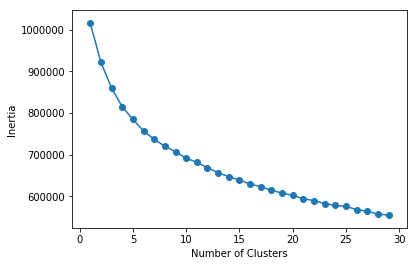

In [26]:
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

try clusters at 10 or 15/16

Component's weights: 
 [[-0.22 -0.22 -0.21 -0.18 -0.21 -0.23 -0.2  -0.24 -0.21 -0.19 -0.21 -0.22
  -0.22 -0.22 -0.22 -0.2  -0.19 -0.22 -0.2  -0.19  0.27  0.19  0.08  0.01
   0.01]
 [ 0.07  0.19 -0.28 -0.14  0.25  0.04 -0.11 -0.32 -0.43 -0.25  0.17  0.3
  -0.01 -0.09  0.22  0.27 -0.24  0.26  0.17 -0.18 -0.01 -0.03  0.03  0.
  -0.  ]]
Perc of Variance Explained: 
 [0.09 0.13]


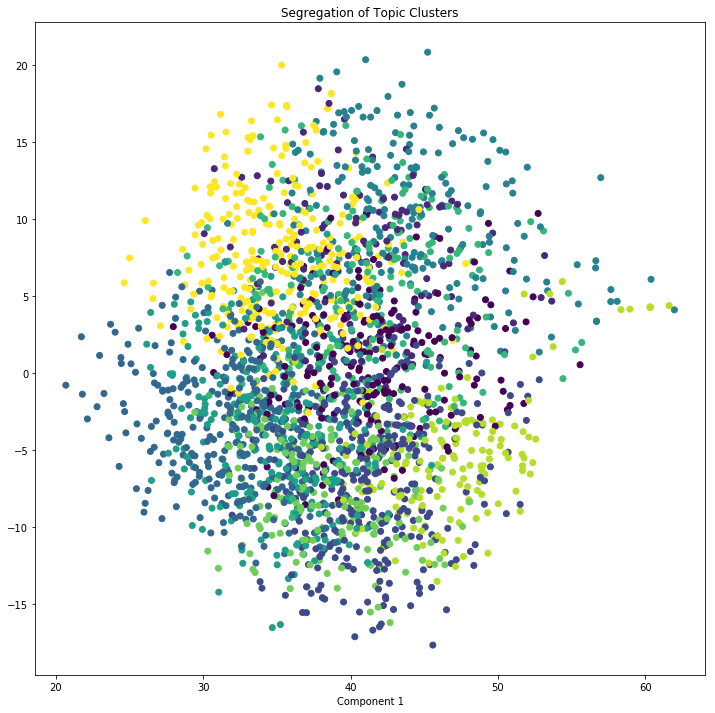

In [27]:
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
clusters = KMeans(n_clusters=10, random_state=RSEED).fit_predict(X)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(X)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
plt.savefig('../images/cluster.svg', format='svg',transparent=True )

### next -> similarity.ipynb